# 1. Import des librairies

In [1]:
import tensorflow as tf
import keras 
import pandas as pd
import seaborn as sns
import numpy as np
import os
import lime
import shape
import eli5
from PIL import Image
import matplotlib.pyplot as plt


2022-04-07 15:43:25.856438: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-07 15:43:25.856464: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 2. Identification des différents chemins des fichiers

In [2]:
# Les différents chemin pour retouver les fichiers images ainsi que le chemin des fichiers des différentes classes

image_dir='/home/titon/Documents/Projet_France_Relance-20220311T093327Z-001/Projet_France_Relance/cell_images'
uninfected='/home/titon/Documents/Projet_France_Relance-20220311T093327Z-001/Projet_France_Relance/cell_images/Uninfected'
parasitized='/home/titon/Documents/Projet_France_Relance-20220311T093327Z-001/Projet_France_Relance/cell_images/Parasitized'

In [3]:
classes=os.listdir(image_dir)
print(classes)

['Parasitized', 'Uninfected']


In [4]:
# Pour lire les images 
from matplotlib.image import imread

In [5]:
## pour voir à quoi ressemble les images depuis le chemin
# liste de tout les fichiers images au format png
para_path=image_dir + '/Parasitized'
noninf_path=image_dir + '/Uninfected'

In [6]:
# la fonction os.listdir: liste toute les images
os.listdir(noninf_path)

['C119P80ThinF_IMG_20151002_123608_cell_94.png',
 'C156P117ThinF_IMG_20151115_154022_cell_64.png',
 'C68P29N_ThinF_IMG_20150819_133447_cell_22.png',
 'C131P92ThinF_IMG_20151004_145302_cell_55.png',
 'C67P28N_ThinF_IMG_20150819_121053_cell_176.png',
 'C161P122ThinF_IMG_20151116_100724_cell_26.png',
 'C147P108ThinF_IMG_20151115_092605_cell_221.png',
 'C143P104ThinF_IMG_20151005_230100_cell_1.png',
 'C180P141NThinF_IMG_20151201_163751_cell_112.png',
 'C128P89ThinF_IMG_20151004_130810_cell_67.png',
 'C188P149ThinF_IMG_20151203_135433_cell_18.png',
 'C67P28N_ThinF_IMG_20150819_121053_cell_140.png',
 'C170P131ThinF_IMG_20151119_120150_cell_121.png',
 'C52P13thinF_IMG_20150725_130013_cell_152.png',
 'C42P5thin_original_IMG_20150623_134547_cell_160.png',
 'C240ThinF_IMG_20151127_115223_cell_121.png',
 'C185P146ThinF_IMG_20151203_110933_cell_220.png',
 'C63P24N_ThinF_IMG_20150818_143319_cell_48.png',
 'C125P86ThinF_IMG_20151004_102132_cell_74.png',
 'C103P64ThinF_IMG_20150918_164250_cell_15.png

In [7]:
para1_cell= Image.open(para_path+'/C82P43ThinF_IMG_20150817_124728_cell_28.png')

In [8]:
# pour voir le chemin de la première image de la cellule infectée
os.listdir(para_path)[0]

'C82P43ThinF_IMG_20150817_124728_cell_28.png'

In [9]:
para_cell=para_path+'/C82P43ThinF_IMG_20150817_124728_cell_28.png'

In [10]:
para_img=imread(para_cell)

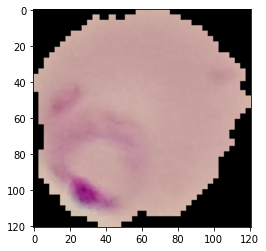

In [11]:
plt.imshow(para_img)

In [12]:
para_img.shape

(121, 121, 3)

In [13]:
# pour voir le chemin de la première image de la cellule non-infectée
os.listdir(noninf_path)[0]

'C119P80ThinF_IMG_20151002_123608_cell_94.png'

In [14]:
noninf_cell= noninf_path +'/C119P80ThinF_IMG_20151002_123608_cell_94.png'

In [15]:
noninf_img=imread(noninf_cell)

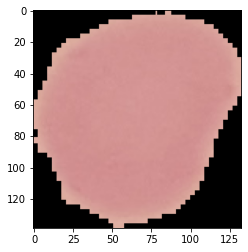

In [16]:
plt.imshow(noninf_img)

In [17]:
# voir le nombre d'images de cellules infectées 
len(os.listdir(para_path))

13780

In [18]:
# voir le nombre d'images de cellules non-infectées 
len(os.listdir(noninf_path))

13780

# 3. Genération du dataset d'entrainement et de validation à partir de ImageDataGenerator 

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data = ImageDataGenerator(rotation_range=20, # Faire pivoter l'image de 20 degrés
                               width_shift_range=0.10, # Modifier la largeur de la photo de 10% maximum
                               height_shift_range=0.10, # Modifier la hauteur de la photo de 10% maximum
                               validation_split = 0.2,
                               # rescale=1/255, # Redimensionner l'image en la normalisant
                               shear_range=0.1, # shear signifie couper une partie de l'image (max 10%)
                               zoom_range=0.1, # Zoom de 10% maximum
                               horizontal_flip=True, # Autorise le basculement horizontal
                               fill_mode='nearest' # Remplir les pixels manquants avec la valeur remplie la plus proche
                              )

In [20]:
# Données d'entraînement à partir de ImageDataGenerator
train_generator = data.flow_from_directory(image_dir,
                                               target_size=(130,130),
                                                color_mode='rgb',
                                                subset='training',
                                               batch_size=16,
                                               class_mode='binary')

Found 22048 images belonging to 2 classes.


In [21]:
# Données de validation à partir de ImageDataGenerator
test_generator = data.flow_from_directory(image_dir,target_size=(130,130),
                                                   batch_size= 16,
                                                   class_mode='binary',
                                                   shuffle=False,
                                                   subset = 'validation')

Found 5510 images belonging to 2 classes.


In [22]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [23]:
test_generator.class_indices

{'Parasitized': 0, 'Uninfected': 1}

# 4. Construction du modèle CNN

In [24]:
# Import des librairies pour la construction du CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Activation,Dropout

image_shape=(130,130,3)

In [25]:
# Dimension moyenne des images dans le dataset


model=Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3),input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Flatten())

model.add(Dense(512,activation='relu'))

# couche droptout permettant de contrôler l'overfitting

model.add(Dropout(0.4))

# Cas d'une classification binaire, pour la dernière couche utilisation de la sigmoïde

model.add(Dense(1,activation='sigmoid'))

# compilation du modèle

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

2022-04-07 15:44:37.739149: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-07 15:44:37.739237: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-07 15:44:37.739295: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hprisser): /proc/driver/nvidia/version does not exist
2022-04-07 15:44:37.765874: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
# Affichage du modèle
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [27]:
#  Earlystopping: Mécanisme d'arrêt anticipé pour contrôler l'overfitting

from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=2)

# Entraînement du modèle

In [175]:
model.fit(train_generator,epochs=20,
                              validation_data=test_generator,
                             callbacks=[early_stop])

Epoch 1/20
1378/1378 [==============================] - 299s 217ms/step - loss: 0.3065 - accuracy: 0.8877 - val_loss: 0.2718 - val_accuracy: 0.9192
Epoch 2/20
1378/1378 [==============================] - 191s 139ms/step - loss: 0.1881 - accuracy: 0.9443 - val_loss: 0.2021 - val_accuracy: 0.9407
Epoch 3/20
1378/1378 [==============================] - 272s 197ms/step - loss: 0.1736 - accuracy: 0.9478 - val_loss: 0.1819 - val_accuracy: 0.9359
Epoch 4/20
1378/1378 [==============================] - 274s 199ms/step - loss: 0.1691 - accuracy: 0.9485 - val_loss: 0.1784 - val_accuracy: 0.9374
Epoch 5/20
1378/1378 [==============================] - 198s 144ms/step - loss: 0.1719 - accuracy: 0.9471 - val_loss: 0.2045 - val_accuracy: 0.9405
Epoch 6/20
1378/1378 [==============================] - 198s 144ms/step - loss: 0.1634 - accuracy: 0.9500 - val_loss: 0.1812 - val_accuracy: 0.9419


In [171]:
model.save('my_model2_cnn.h5')

In [176]:
metrics=pd.DataFrame(model.history.history)

<AxesSubplot:>

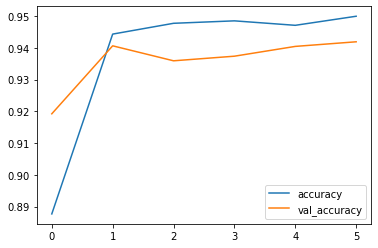

In [177]:
metrics[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

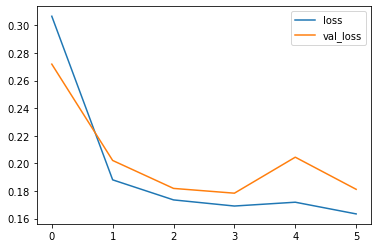

In [178]:
metrics[['loss','val_loss']].plot()

In [179]:
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.306530,0.887700,0.271848,0.919238
1,0.188076,0.944349,0.202110,0.940653
2,0.173558,0.947750,0.181878,0.935935
3,0.169121,0.948521,0.178422,0.937387
4,0.171884,0.947115,0.204480,0.940472
5,0.163411,0.949973,0.181224,0.941924


In [196]:
# Calcul des probabilités de classification
pred_probabilities = model.predict(test_generator)

In [197]:
predictions=pred_probabilities>0.5

In [198]:
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [199]:
from sklearn.metrics import classification_report,confusion_matrix

In [200]:
print(classification_report(test_generator.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2755
           1       0.93      0.96      0.94      2755

    accuracy                           0.94      5510
   macro avg       0.94      0.94      0.94      5510
weighted avg       0.94      0.94      0.94      5510



In [201]:
print(confusion_matrix(test_generator.classes,predictions))

[[2560  195]
 [ 118 2637]]


# Prediction pour une image

In [252]:
img = tf.keras.utils.load_img(para_cell, target_size=image_shape)

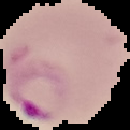

In [253]:
img

In [254]:
img_array = tf.keras.utils.img_to_array(img)

In [255]:
img_array = tf.expand_dims(img_array, 0) 

In [293]:
img_array.shape

TensorShape([1, 130, 130, 3])

In [261]:
predictions =(model.predict(img_array) > 0.5).astype('int32')

In [262]:
predictions

array([[0]], dtype=int32)

In [301]:
test_image_gen.class_indices

{'Parasitized': 0, 'Uninfected': 1}

# Explicabilité de la prédiction faite par le modèle CNN sur l'image 

In [187]:
from lime import lime_image

In [291]:
explainer=lime_image.LimeImageExplainer()

In [ ]:

explanation= explainer.explain_instance(img_array, model.predict,top_labels=2, hide_color=0,num_samples=1000)